# Set up Phoenix

In [1]:
from phoenix.otel import register
from openinference.instrumentation.openai import OpenAIInstrumentor
import os
from opentelemetry.trace import Status, StatusCode
from openinference.semconv.trace import SpanAttributes
from time import sleep 

project_name = "Basic_RAG"

# Add Phoenix API Key for tracing
phoenix_key = ''
with open('phoenix_key.txt', 'r') as file:
    phoenix_key = file.read()
os.environ["PHOENIX_CLIENT_HEADERS"] = f"api_key={phoenix_key}"
os.environ["PHOENIX_COLLECTOR_ENDPOINT"] = "https://app.phoenix.arize.com"
os.environ["OTEL_EXPORTER_OTLP_HEADERS"] = f"api_key={phoenix_key}";
os.environ['PHOENIX_PROJECT_NAME'] = project_name


# Basic imports and setups

In [2]:
import nest_asyncio
import pandas as pd
import phoenix as px
from basic_rag import MilvusKnowledgeStorage, get_paragraphs

nest_asyncio.apply()

Overriding of current TracerProvider is not allowed
Attempting to instrument while already instrumented


🔭 OpenTelemetry Tracing Details 🔭
|  Phoenix Project: Basic_RAG
|  Span Processor: SimpleSpanProcessor
|  Collector Endpoint: https://app.phoenix.arize.com/v1/traces
|  Transport: HTTP + protobuf
|  Transport Headers: {'api_key': '****'}
|  
|  Using a default SpanProcessor. `add_span_processor` will overwrite this default.
|  
|  ⚠️ WARNING: It is strongly advised to use a BatchSpanProcessor in production environments.
|  
|  `register` has set this TracerProvider as the global OpenTelemetry default.
|  To disable this behavior, call `register` with `set_global_tracer_provider=False`.



W0828 18:17:45.523000 61156 site-packages/torch/distributed/elastic/multiprocessing/redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


## Load best dataset from Phoenix

Generated the answer with Anthropic Claude 3 Opus model. No noise

In [3]:
phoenix_client = px.Client()

/Users/Attila_Sajo/miniconda3/envs/ds/lib/python3.11/site-packages/phoenix/utilities/client.py:60: UserWarning: The Phoenix server (11.28.0) and client (11.19.0) versions are mismatched and may have compatibility issues.
  warnings.warn(


In [4]:
dataset_phoenix_name = "qa_data_rio"
df_best = pd.read_json(f"./{dataset_phoenix_name}.json")

In [5]:
df_best.to_json("dataset_phoenix_name2.json", orient="records", indent=4)

In [6]:
try:
    dataset_best = phoenix_client.upload_dataset(
        dataframe=df_best,
        dataset_name=dataset_phoenix_name,
        input_keys=["question"],
        output_keys=["human",  "chatgpt"],
    )
except Exception as e:
    dataset_best = phoenix_client.get_dataset(name=dataset_phoenix_name)

📤 Uploading dataset...


# Write Phoenix evaluation

In [7]:
from phoenix.experiments.evaluators.base import EvaluationResult, Evaluator

In [8]:
from typing import Any, Dict
import torch
from bert_score import score

class BERTScore(Evaluator):
    name="BERT Score"
    def evaluate(self, output: str, expected: Dict[str, Any], **kwargs) -> EvaluationResult:
        expected_answer = expected["human"]

        # compute Bert score
        # presission, recall and F1
        P, R, F1 = score([output], [expected_answer], lang="en", model_type="ProsusAI/finbert")
        return EvaluationResult(score=F1.numpy(force=True)[0])

In [9]:
import tensorflow_hub as hub
from scipy.spatial import distance

class USESimilarity(Evaluator):
    name="USE"
    def __init__(self):
        super().__init__()
        self.embed = hub.load("https://www.kaggle.com/models/google/universal-sentence-encoder/TensorFlow2/universal-sentence-encoder/2")
    def evaluate(self, output: str, expected, **kwargs) -> EvaluationResult:
        embeddings = self.embed([
            output,
            expected["human"]
        ])

        similarity = 1 - distance.cosine(embeddings[0], embeddings[1])
        return EvaluationResult(score=similarity)

uses = USESimilarity()

In [10]:
from nltk.translate.meteor_score import single_meteor_score
import nltk
"""
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
"""

import re
from nltk.corpus import stopwords

stop_word_list = stopwords.words('english')


def my_tokkenizer(text):
    # különleges karakterek
    pattern = r"[{}]".format("(),.;:%\"") 
    text = re.sub(pattern, "", text)
    
    # kisbetű
    text = text.lower()
    # felesleges üres mezők törlése 
    text = text.strip()
 
    # szavakra vágás
    from nltk.tokenize import WordPunctTokenizer
    WPT = WordPunctTokenizer()
    tokens = WPT.tokenize(text)

    # stop szavak eltávolítása
    filtered_tokens = [
        token for token in tokens 
        if token not in stop_word_list
    ]
    
    # Lemmatize do not need as METEOR handle this also

    return filtered_tokens

class Meteor(Evaluator):
    name="METEOR"
    def evaluate(self, output: str, expected, **kwargs) -> EvaluationResult:
        score = single_meteor_score(my_tokkenizer(output), my_tokkenizer(expected["human"]))
        return EvaluationResult(score=score)

In [11]:
from scipy.spatial.distance import euclidean
from sentence_transformers import SentenceTransformer, SimilarityFunction

class SBERTFinance(Evaluator):
    name="SBERT finance"
    def __init__(self):
        super().__init__()
        self.model = SentenceTransformer(
            "FinLang/finance-embeddings-investopedia", 
            similarity_fn_name=SimilarityFunction.COSINE
        )
    def evaluate(self, output: str, expected, **kwargs) -> EvaluationResult:
        rag_answer_embeddings = self.model.encode([output])
        expected_embeddings = self.model.encode([expected["human"]])
        similarity = self. model.similarity(rag_answer_embeddings, expected_embeddings)
        return EvaluationResult(score=similarity.numpy(force=True)[0][0])

finance = SBERTFinance()

In [12]:
class SBERTQwen4(Evaluator):
    name="SBERT Qwen3 4B"
    def __init__(self):
        super().__init__()
        self.model = SentenceTransformer(
            "Qwen/Qwen3-Embedding-4B", 
            similarity_fn_name=SimilarityFunction.COSINE,
            tokenizer_kwargs={"padding_side": "left"},
        )
    def evaluate(self, output: str, expected, **kwargs) -> EvaluationResult:
        rag_answer_embeddings = self.model.encode([output])
        expected_embeddings = self.model.encode([expected["human"]])
        similarity = self.model.similarity(rag_answer_embeddings, expected_embeddings)
        return EvaluationResult(score=similarity.numpy(force=True)[0][0])

class SBERTQwen06(Evaluator):
    name="SBERT Qwen3 0.6B"
    def __init__(self):
        super().__init__()
        self.model = SentenceTransformer(
            "Qwen/Qwen3-Embedding-0.6B", 
            similarity_fn_name=SimilarityFunction.COSINE,
            model_kwargs={"device_map": "auto"},
            tokenizer_kwargs={"padding_side": "left"},
        )
    def evaluate(self, output: str, expected, **kwargs) -> EvaluationResult:
        rag_answer_embeddings = self.model.encode([output])
        expected_embeddings = self.model.encode([expected["human"]])
        similarity = self.model.similarity(rag_answer_embeddings, expected_embeddings)
        return EvaluationResult(score=similarity.numpy(force=True)[0][0])

# qwen4 = SBERTQwen4()
qwen06 = SBERTQwen06()

# Evaluate basic RAG

In [13]:
from phoenix.experiments.types import Example
from basic_rag import MyRAG
from phoenix.experiments import run_experiment

def task(input, expected) -> str:
    question = input['question']
    
    
    # mock the RAG generation
    rag_answer = MyRAG().invoke(question)
    
    return rag_answer


In [14]:
df_all_result = pd.DataFrame()

splitting_sets = [
    {
        "splitter": "Semantic", 
        "model_name": "Qwen/Qwen3-Embedding-0.6B",
        "breakpoint_threshold_type": "percentile",
        "breakpoint_threshold_amount": 70.0
    },
    {
        "splitter": "Semantic", 
        "model_name": "Qwen/Qwen3-Embedding-0.6B",
        "breakpoint_threshold_type": "percentile",
        "breakpoint_threshold_amount": 50.0
    },
    {
        "splitter": "Semantic", 
        "model_name": "Qwen/Qwen3-Embedding-0.6B",
        "breakpoint_threshold_type": "standard_deviation",
        "breakpoint_threshold_amount": 1.25
    },
    {
        "splitter": "Semantic", 
        "model_name": "Qwen/Qwen3-Embedding-0.6B",
        "breakpoint_threshold_type": "standard_deviation",
        "breakpoint_threshold_amount": 2
    },
        {
        "splitter": "Semantic", 
        "model_name": "FinLang/finance-embeddings-investopedia",
        "breakpoint_threshold_type": "percentile",
        "breakpoint_threshold_amount": 70.0
    },
    {
        "splitter": "Semantic", 
        "model_name": "FinLang/finance-embeddings-investopedia",
        "breakpoint_threshold_type": "percentile",
        "breakpoint_threshold_amount": 50.0
    },
    {
        "splitter": "Semantic", 
        "model_name": "FinLang/finance-embeddings-investopedia",
        "breakpoint_threshold_type": "standard_deviation",
        "breakpoint_threshold_amount": 1.25
    },
    {
        "splitter": "Semantic", 
        "model_name": "FinLang/finance-embeddings-investopedia",
        "breakpoint_threshold_type": "standard_deviation",
        "breakpoint_threshold_amount": 2
    }
]

In [15]:
splitting_sets = [
    {
        "splitter": "RecursiveCharacter",
        "chunk_overlap": 300,
        "chunk_size": 1500
    },
    {
        "splitter": "RecursiveCharacter",
        "chunk_overlap": 200,
        "chunk_size": 1000
    }
]

In [16]:
# run the different experiments
for splitting_setting in splitting_sets:
    
    paragraphs = get_paragraphs(
        ticker="RIO",
        **splitting_setting  # Unpack the rest of the settings dynamically
    )

    try:
        knowledge = MilvusKnowledgeStorage()
    except:
        # retry
        sleep(1)
        knowledge = MilvusKnowledgeStorage()
    knowledge.initialize_knowledge_storage()

    # load data
    documents = [ doc.page_content for doc in paragraphs]
    metadata = [ doc.metadata for doc in paragraphs]
    knowledge.save(documents=documents, metadata=metadata)

    experiment = run_experiment(
        dataset_best,
        task,
        experiment_name="rag-experiment",
        evaluators=[qwen06, BERTScore() ],
        experiment_metadata=splitting_setting
    )

    evaluation_result = experiment.get_evaluations()

    evaluation_result_filtered = pd.DataFrame({
        "name": evaluation_result["name"].values,
        "score": evaluation_result["score"].values,
        "setting": str(splitting_setting)
    })

    df_all_result = pd.concat([df_all_result, evaluation_result_filtered])


Processing: knowledge/rio_20231009_20231009_qa_1.pdf file
Processing: knowledge/rio_20240924_20240924_qa_1.pdf file
Processing: knowledge/rio_20230711_20230711_qa_1.pdf file
Processing: knowledge/rio_20241009_20241009_qa_1.pdf file
Processing: knowledge/rio_20250101_20250501_qa_1.pdf file
Create knowledge collection
Loading data. Size: 49680
🧪 Experiment started.
📺 View dataset experiments: https://app.phoenix.arize.com/datasets/RGF0YXNldDoxMw==/experiments
🔗 View this experiment: https://app.phoenix.arize.com/datasets/RGF0YXNldDoxMw==/compare?experimentId=RXhwZXJpbWVudDo2MQ==


/Users/Attila_Sajo/miniconda3/envs/ds/lib/python3.11/site-packages/phoenix/utilities/client.py:60: UserWarning: The Phoenix server (11.28.0) and client (11.19.0) versions are mismatched and may have compatibility issues.
  warnings.warn(


running tasks |          | 0/22 (0.0%) | ⏳ 00:00<? | ?it/s

✅ Task runs completed.
🧠 Evaluation started.


running experiment evaluations |          | 0/44 (0.0%) | ⏳ 00:00<? | ?it/s

/Users/Attila_Sajo/miniconda3/envs/ds/lib/python3.11/site-packages/phoenix/utilities/client.py:60: UserWarning: The Phoenix server (11.28.0) and client (11.19.0) versions are mismatched and may have compatibility issues.
  warnings.warn(



🔗 View this experiment: https://app.phoenix.arize.com/datasets/RGF0YXNldDoxMw==/compare?experimentId=RXhwZXJpbWVudDo2MQ==

Experiment Summary (08/28/25 06:25 PM +0200)
--------------------------------------------
| evaluator        |   n |   n_scores |   avg_score |
|:-----------------|----:|-----------:|------------:|
| BERT Score       |  22 |         22 |    0.542855 |
| SBERT Qwen3 0.6B |  22 |         22 |    0.541399 |

Tasks Summary (08/28/25 06:25 PM +0200)
---------------------------------------
|   n_examples |   n_runs |   n_errors |
|-------------:|---------:|-----------:|
|           22 |       22 |          0 |
Processing: knowledge/rio_20231009_20231009_qa_1.pdf file
Processing: knowledge/rio_20240924_20240924_qa_1.pdf file
Processing: knowledge/rio_20230711_20230711_qa_1.pdf file
Processing: knowledge/rio_20241009_20241009_qa_1.pdf file
Processing: knowledge/rio_20250101_20250501_qa_1.pdf file
Create knowledge collection
Loading data. Size: 72864
🧪 Experiment started.


/Users/Attila_Sajo/miniconda3/envs/ds/lib/python3.11/site-packages/phoenix/utilities/client.py:60: UserWarning: The Phoenix server (11.28.0) and client (11.19.0) versions are mismatched and may have compatibility issues.
  warnings.warn(


running tasks |          | 0/22 (0.0%) | ⏳ 00:00<? | ?it/s

✅ Task runs completed.
🧠 Evaluation started.


running experiment evaluations |          | 0/44 (0.0%) | ⏳ 00:00<? | ?it/s

/Users/Attila_Sajo/miniconda3/envs/ds/lib/python3.11/site-packages/phoenix/utilities/client.py:60: UserWarning: The Phoenix server (11.28.0) and client (11.19.0) versions are mismatched and may have compatibility issues.
  warnings.warn(



🔗 View this experiment: https://app.phoenix.arize.com/datasets/RGF0YXNldDoxMw==/compare?experimentId=RXhwZXJpbWVudDo2Mg==

Experiment Summary (08/28/25 06:33 PM +0200)
--------------------------------------------
| evaluator        |   n |   n_scores |   avg_score |
|:-----------------|----:|-----------:|------------:|
| BERT Score       |  22 |         22 |    0.526186 |
| SBERT Qwen3 0.6B |  22 |         22 |    0.5445   |

Tasks Summary (08/28/25 06:32 PM +0200)
---------------------------------------
|   n_examples |   n_runs |   n_errors |
|-------------:|---------:|-----------:|
|           22 |       22 |          0 |


In [17]:
import plotly.express as plotly_express
import plotly.graph_objects as plotly_go

custom_template = {
    "layout": plotly_go.Layout(
        font={
            "family": "Nunito",
            "size": 12,
            "color": "#707070",
        },
        title={
            "font": {
                "family": "Lato",
                "size": 18,
                "color": "#1f1f1f",
            },
        },
        plot_bgcolor="#ffffff",
        paper_bgcolor="#ffffff",
        colorway=plotly_express.colors.qualitative.G10,
    )
}

def format_title(title, subtitle=None, subtitle_font_size=14):
    title = f'<b>{title}</b>'
    if not subtitle:
        return title
    subtitle = f'<span style="font-size: {subtitle_font_size}px;">{subtitle}</span>'
    return f'{title}<br>{subtitle}'

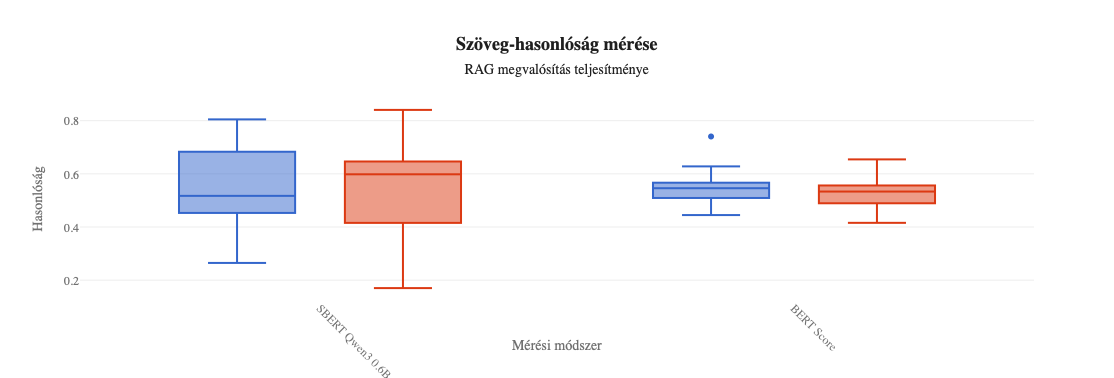

In [18]:
# Create a boxplot using Plotly
fig = plotly_express.box(
    df_all_result,
    x="name",
    y="score",
    color="setting",
    title=format_title("Szöveg-hasonlóság mérése", "RAG megvalósítás teljesítménye"),
    labels={"name": "Evaluation Type", "score": "Similarity Score",  "setting": "Setting"},
    template=custom_template
)

# Customize the layout
fig.update_layout(
    xaxis_title="Mérési módszer",
    yaxis_title="Hasonlóság",
    xaxis=dict(tickangle=45),
    showlegend=False
)

# Show the plot
fig.show()

In [19]:
df_all_result.to_json("rio_validation.json", orient="records")

# Cleaning up

To cleanup the unnecessary HuggingFace models run the following command: huggingface-cli delete-cache